In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from skimage.draw import disk
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf


In [6]:
def create_mask_from_json(json_data, shape):
    mask = np.zeros(shape, dtype=np.float32)
    for item in json_data:
        rr, cc = disk((item['y'], item['x']), 0, shape=shape)  # '16' is an arbitrary radius for the core
        mask[rr, cc] = 1.0
    return mask

def load_images_and_labels(image_dir, label_dir):
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.png')]
    label_files = [os.path.join(label_dir, file) for file in sorted(os.listdir(label_dir)) if file.endswith('.json')]
    
    images = []
    masks = []

    for image_file, label_file in zip(image_files, label_files):
        # Load image
        image = img_to_array(load_img(image_file, color_mode='rgb'))  # or 'rgb' if your images are colored
        images.append(image / 255.0)  # Normalizing to [0, 1]

        # Load corresponding label
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        mask = create_mask_from_json(json_data, shape=(1024, 1024))
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, 1024, 1024, 1)

# Usage
image_dir = './TMA_WSI_Padded_PNGs'
label_dir = './TMA_WSI_Labels_updated'
images, masks = load_images_and_labels(image_dir, label_dir)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def verify_masks(images, masks, num_samples=3, mask_alpha=0.3):
    """
    This function overlays the mask onto the image to verify position and size.
    Parameters:
    - images: numpy array of images.
    - masks: numpy array of masks.
    - num_samples: number of samples to display for verification.
    - mask_alpha: transparency level of the mask overlay.
    """
    # Set the number of images to display
    num_samples = min(num_samples, len(images))

    # Create figure to display images and masks
    plt.figure(figsize=(20, num_samples * 10))

    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.imshow(masks[i].squeeze(), cmap='jet', alpha=mask_alpha)  # 'jet' colormap for the mask
        plt.title(f'Image {i} with Mask Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function after loading your images and masks
verify_masks(images, masks, num_samples=19, mask_alpha=0.3)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation

In [8]:
def conv_block(input_tensor, num_filters, kernel_size=3, do_batch_norm=True):
    # A conv block consists of two convolutions, each followed by a batch normalization and a relu activation.
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(input_size=(1024, 1024, 3), num_filters=64, depth=4, dropout=0.5, batch_norm=True):
    # INPUT LAYER
    inputs = Input(input_size)
    # CONTRACTING PATH
    conv_blocks = []
    x = inputs
    for i in range(depth):
        x = conv_block(x, num_filters * (2**i), do_batch_norm=batch_norm)
        conv_blocks.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        if dropout:
            x = Dropout(dropout)(x)

    # BOTTLENECK
    x = conv_block(x, num_filters * (2**(depth)), do_batch_norm=batch_norm)
    
    # EXPANSIVE PATH
    for i in reversed(range(depth)):
        num_filters_exp = num_filters * (2**i)
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, conv_blocks[i]], axis=3)
        x = conv_block(x, num_filters_exp, do_batch_norm=batch_norm)

    # FINAL CONVOLUTION
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)

    return model



In [9]:
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 1024, 64)       256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 1024, 64)       0         ['batch_normalization[0][0

In [10]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import os

def weighted_binary_crossentropy(zero_weight, one_weight):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        return K.mean(weighted_bce)
    return loss

# You would then compile your model with this loss, adjusting the weights as needed for your imbalance
def train_unet(model, images, masks, epochs=5, batch_size=2, checkpoint_path='pixel_cores.hdf5'):
    # Define the custom loss function
    custom_loss = weighted_binary_crossentropy(zero_weight=1, one_weight=4200)

    # Check if a previous checkpoint exists
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from checkpoint: {checkpoint_path}")
        # Load the model with the custom loss function
        model = load_model(checkpoint_path, custom_objects={'loss': custom_loss})
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Compile the model with the custom loss function
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=custom_loss, metrics=['AUC'])
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
    
    # Fit the model
    history = model.fit(images, masks, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1, callbacks=[model_checkpoint])
    
    return history


# Using the functions
history = train_unet(model, images, masks)


No checkpoint found. Starting training from scratch.
Epoch 1/5
4/9 [============>.................] - ETA: 9:30 - loss: 0.0070 - auc: 0.0000e+00 

1/1 [==============================] - 13s 13s/step


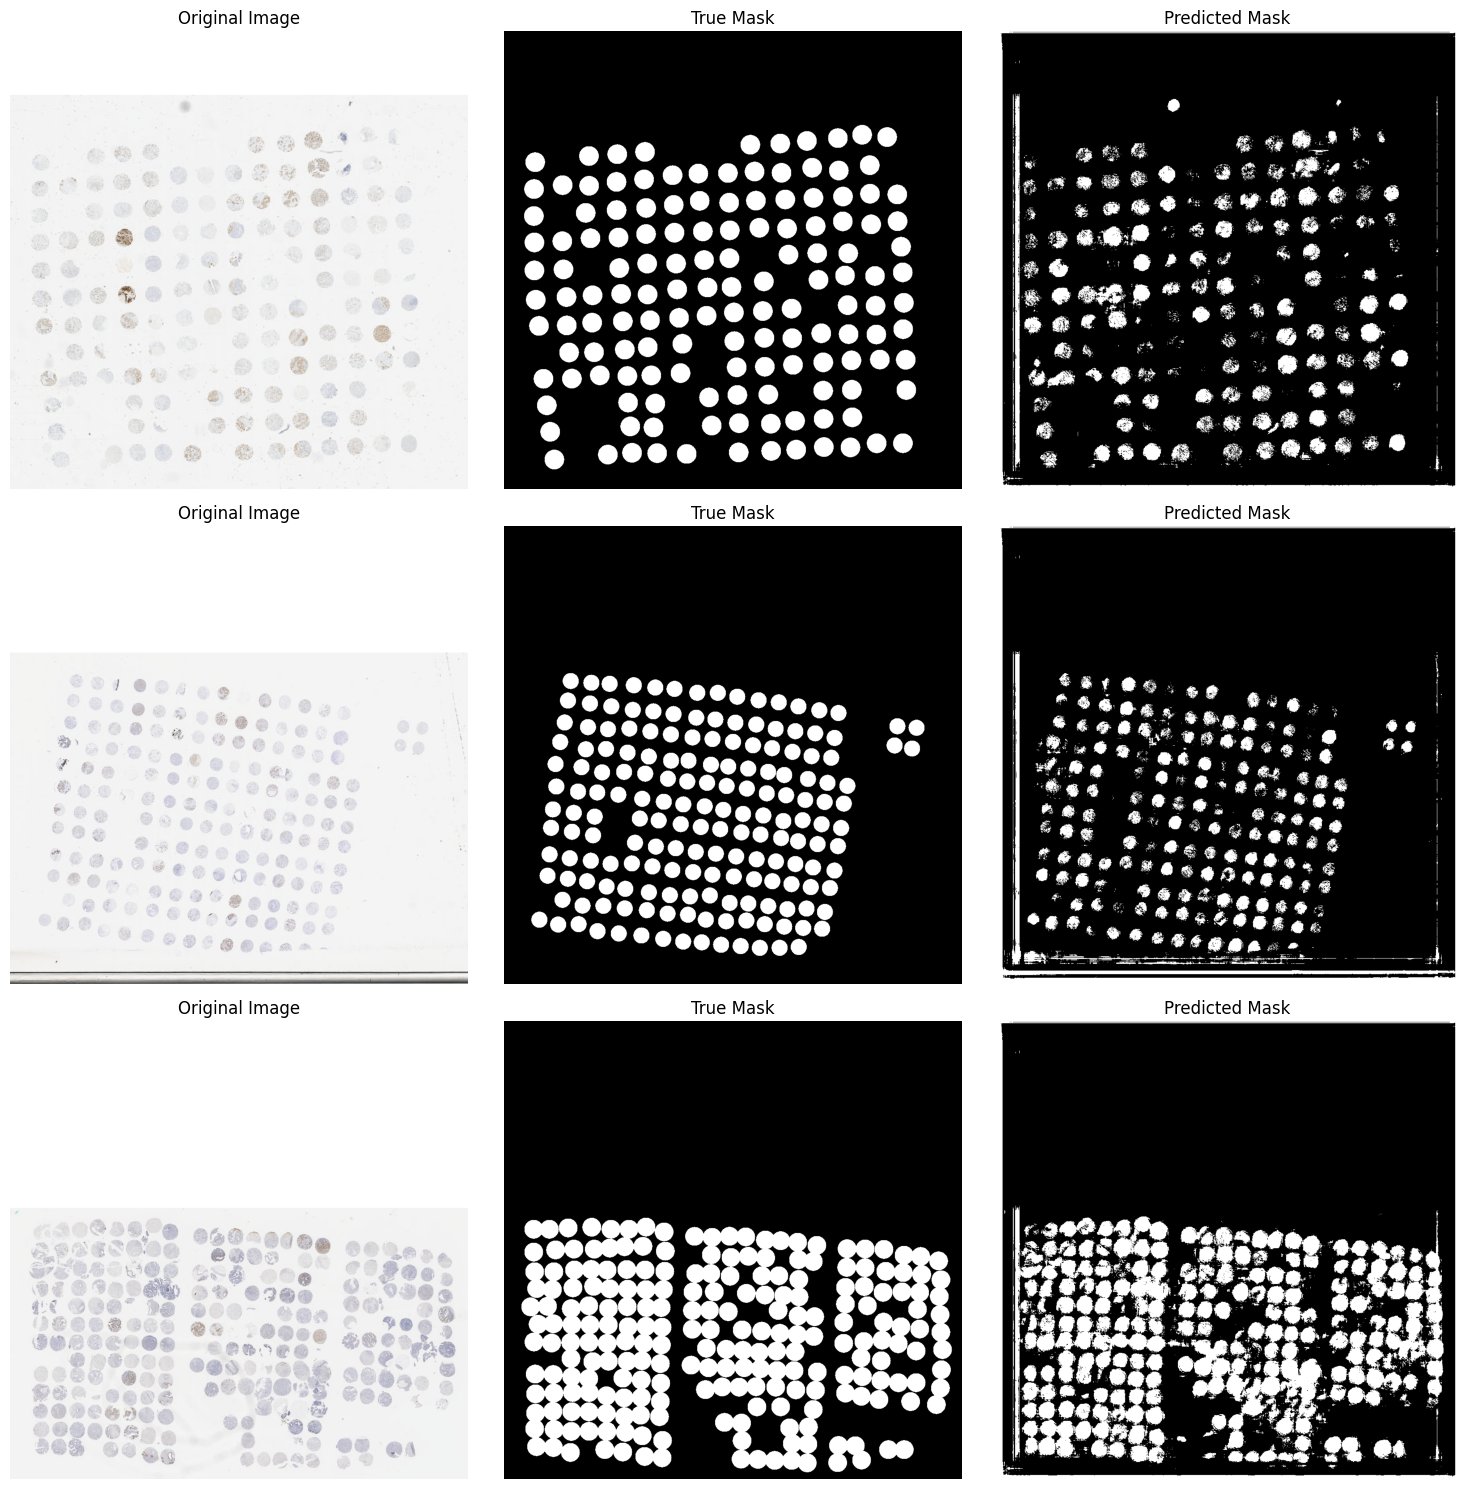

In [34]:
def plot_training_predictions(model, training_images, training_masks, num_samples=3):
    # Make sure there is enough data for the number of samples requested
    if num_samples > len(training_images):
        num_samples = len(training_images)
        print(f"Number of available samples is less than requested. Setting num_samples to {num_samples}.")

    # Randomly select some samples from the training images and masks
    indices = np.random.choice(len(training_images), num_samples, replace=False)
    sample_images = np.array([training_images[i] for i in indices])
    sample_masks = np.array([training_masks[i] for i in indices])

    # Generate predictions for the sample_images
    predicted_masks = model.predict(sample_images)

    # Convert predicted masks to binary
    binary_predicted_masks = (predicted_masks > 0.114).astype(np.uint8)

    # Set up the matplotlib figure and axes, based on the number of samples
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)  # If only one sample, make sure axes are iterable

    for i in range(num_samples):
        # Display original image
        axes[i, 0].imshow(np.squeeze(sample_images[i]), cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        # Display true mask for the image
        sample_masks = np.squeeze(sample_masks[i])
        rr, cc = disk((np.where(sample_masks > 0)), 16, shape=sample_masks.shape)
        sample_masks[rr, cc] = 1
        axes[i, 1].imshow(sample_masks, cmap='gray')
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis('off')

        # Display predicted mask for the image
        binary_predicted_mask = np.squeeze(binary_predicted_masks[i])
        rr, cc = disk((np.where(binary_predicted_mask > 0)), 16, shape=binary_predicted_mask.shape)
        binary_predicted_mask[rr, cc] = 1
        axes[i, 2].imshow(binary_predicted_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

plot_training_predictions(model, images, masks)
